## Questionnaire Analysis

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# 1) Load the raw responses
file_path = "../FairnessinMachineLearning(Responses).xlsx"
df = pd.ExcelFile(file_path).parse("Form responses 1")
n = len(df)

### Participant Background

In [36]:
role_col       = [c for c in df.columns if c.startswith("Which option best")][0]
tech_col       = [c for c in df.columns if c.startswith("How did you acquire")][0]
region_col     = [c for c in df.columns if c.startswith("In which region")][0]
exp_years_col  = [c for c in df.columns if c.startswith("How many years of experience")][0]
fairness_col   = [c for c in df.columns if c.startswith("Sensitive attributes refer")][0]

# Encode ML‑experience tiers (Entry / Junior / Mid / Senior) Q4
exp_map = {
    "Less than 1 year": "Entry (<1 yr)",
    "1–3 years": "Junior (1–3 yrs)",
    "4–6 years": "Mid (4–6 yrs)",
    "More than 6 years": "Senior (>6 yrs)",
}
df["Experience_Level"] = df[exp_years_col].map(exp_map)

# Encode fairness‑project experience (Q5) to ordinal
fairness_map = {
    "I haven’t worked on fairness or used sensitive attributes": "None",
    "I’ve handled sensitive attributes but haven’t explicitly addressed fairness": "Attribute_Only",
    "I’ve worked on fairness issues occasionally or indirectly, including use of sensitive attributes": "Attributes_and_Addresses",
}
df["Fairness_Experience"] = df[fairness_col].map(fairness_map)

def count_percent(series):
    counts = series.value_counts(dropna=True)
    return pd.DataFrame({
        "Count": counts,
        "Percent": (counts / n * 100).round(1)
    })

In [37]:
# ---------- Q1: ROLE ----------
print("\n=== Q1 – Current role ===")
role_stats = count_percent(df[role_col])
print(role_stats)

# ---------- Q2: TECHNICAL BACKGROUND (multi‑select) ----------
print("\n=== Q2 – Technical background (multi‑select) ===")
tech_counter = Counter()
for entry in df[tech_col].dropna():
    for item in [t.strip() for t in entry.split(",")]:
        tech_counter[item] += 1

tech_items = list(tech_counter.items())
tech_stats = pd.DataFrame(
    {"Category": [k for k, v in tech_items],
     "Count": [v for k, v in tech_items],
     "Percent": [round(v / n * 100, 1) for _, v in tech_items]}
).sort_values("Count", ascending=False).set_index("Category")
print(tech_stats)

# ---------- Q3: REGION ----------
print("\n=== Q3 – Work region ===")
region_stats = count_percent(df[region_col])
print(region_stats)

# ---------- Q4: ML EXPERIENCE TIER ----------
print("\n=== Q4 – ML experience (encoded) ===")
exp_stats = count_percent(df["Experience_Level"])
print(exp_stats)

# ---------- Q5: FAIRNESS‑PROJECT EXPERIENCE ----------
print("\n=== Q5 – Fairness‑project experience ===")
fair_stats = count_percent(df["Fairness_Experience"])
print(fair_stats)


=== Q1 – Current role ===
                                                Count  Percent
Which option best describes your current role?                
ML/AI Engineer or Data Scientist/Analyst           11     55.0
Student Computer/Data Science etc.                  6     30.0
Software Engineer / Developer                       3     15.0

=== Q2 – Technical background (multi‑select) ===
                                   Count  Percent
Category                                         
Bachelor’s degree (e.g.               10     50.0
CS                                    10     50.0
DS                                    10     50.0
ML courses)                           10     50.0
On-the-job learning                   10     50.0
Master's or PhD-level degree           9     45.0
Self-taught (e.g.                      8     40.0
online courses                         8     40.0
tutorials)                             8     40.0
Bootcamp or certification program      4     20.0

=== Q3 

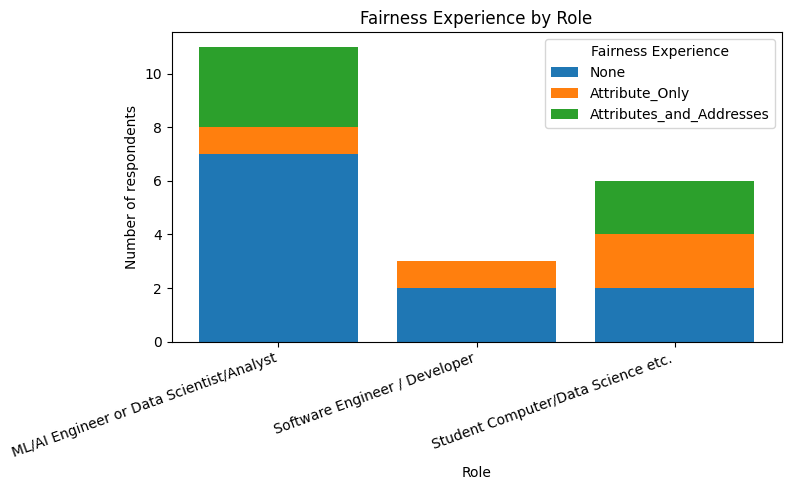

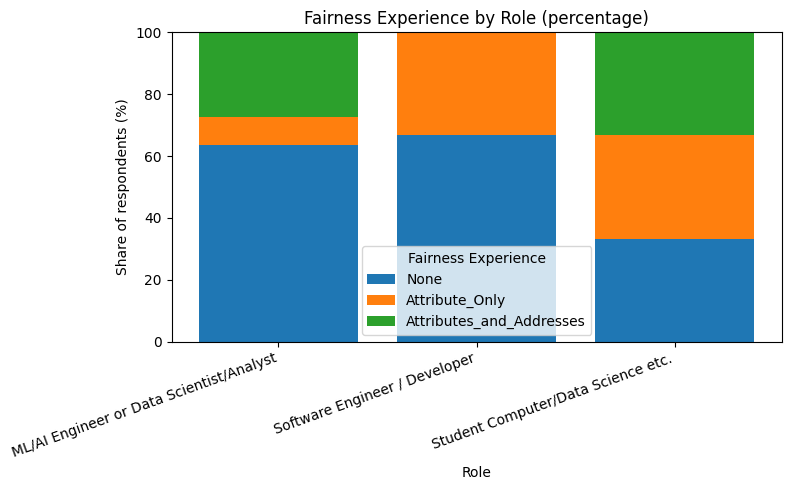

In [51]:

contingency_dynamic = pd.crosstab(df[role_col], df["Fairness_Experience"])
ordered_cols = ["None", "Attribute_Only", "Attributes_and_Addresses"]
contingency_dynamic = contingency_dynamic[[col for col in ordered_cols if col in contingency_dynamic.columns]]

# Plot nuemric
fig, ax = plt.subplots(figsize=(8, 5))
bottom = None
for exp_level in contingency_dynamic.columns:
    counts = contingency_dynamic[exp_level]
    ax.bar(
        contingency_dynamic.index,
        counts,
        bottom=bottom,
        label=exp_level
    )
    bottom = counts if bottom is None else bottom + counts

ax.set_xlabel("Role")
ax.set_ylabel("Number of respondents")
ax.set_title("Fairness Experience by Role")
ax.legend(title="Fairness Experience")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

contingency_pct = contingency_dynamic.div(contingency_dynamic.sum(axis=1), axis=0) * 100

# Plot percentage (normalized)
fig, ax = plt.subplots(figsize=(8, 5))
bottom = None
for exp_level in contingency_pct.columns:
    pct_values = contingency_pct[exp_level]
    ax.bar(contingency_pct.index,
           pct_values,
           bottom=bottom,
           label=exp_level)
    bottom = pct_values if bottom is None else bottom + pct_values

ax.set_xlabel("Role")
ax.set_ylabel("Share of respondents (%)")
ax.set_title("Fairness Experience by Role (percentage)")
ax.legend(title="Fairness Experience")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


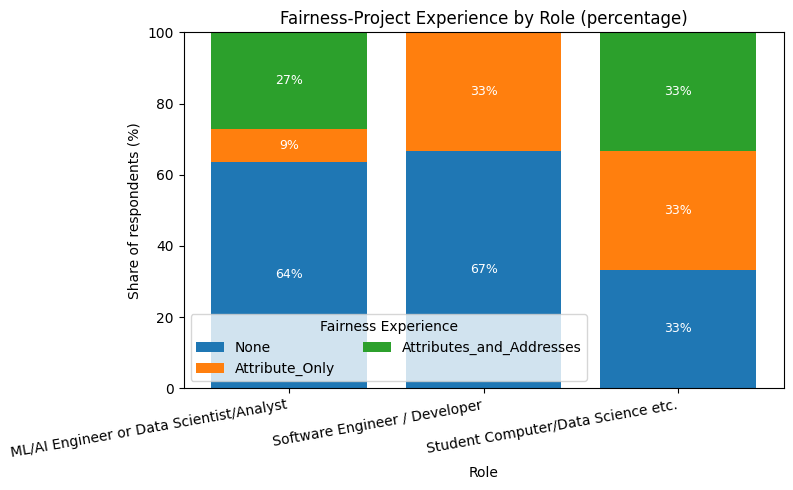

In [52]:
# normalized plot, add numbers, fix format
fig, ax = plt.subplots(figsize=(8, 5))
bottom = pd.Series([0] * len(contingency_pct), index=contingency_pct.index)

for exp_level in contingency_pct.columns:
    
    pct_values = contingency_pct[exp_level]
    bars = ax.bar(
        contingency_pct.index,
        pct_values,
        bottom=bottom,
        label=exp_level
    )
    # Add text labels
    for bar, pct in zip(bars, pct_values):
        if pct == 0:
            continue         
        ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_y() + bar.get_height() / 2,
        f"{pct:.0f}%",
        ha="center",
        va="center",
        fontsize=9,
        color="white"
        )
    bottom += pct_values     

# Axis / legend styling
ax.set_xlabel("Role")
ax.set_ylabel("Share of respondents (%)")
ax.set_title("Fairness-Project Experience by Role (percentage)")
ax.set_ylim(0, 100)
ax.legend(title="Fairness Experience",
          loc="lower left",
          bbox_to_anchor=(0, 0.0),
          ncol=2) 

plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()